In [2]:
!pip install torch

     -------------------------------------- 172.4/172.4 MB 3.4 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [4]:
def show_image(image,label,get_denormalize=True):
    image=image.permute(1,2,0)
    # PyTorch modules dealing with image data require tensors to be laid out as (C × H × W) : channels, height, and width, respectively.
    # Note how we have to use permute to change the order of the axes from (C × H × W) to (H × W × C) to match what Matplotlib expects.
    mean=torch.FloatTensor([0.485,0.456,0.406])
    std=torch.FloatTensor([0.229,0.224,0.225]) 
    # for normalizing the data
    
    
    if get_denormalize==True:
        image=image*std+mean # normalizing
        image=np.clip(image,0,1) 
        # Given an interval, values outside the interval are clipped to the interval edges.
        # For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.
        plt.imshow(image)
        plt.title(label)
        
    else:
        plt.imshow(image)
        plt.title(label)

In [5]:
def show_grid(image,title=None):
    image=image.permute(1,2,0)
    mean=torch.FloatTensor([0.485,0.456,0.406])
    std=torch.FloatTensor([0.229,0.224,0.225])

    image=image*std+mean
    image=np.clip(image,0,1)
    
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    
    if title!=None:
        plt.title(title)

In [6]:
def accuracy(y_pred,y_true):
    y_pred=F.softmax(y_pred,dim=1) #applying softmax
    top_p,top_class=y_pred.topk(1,dim=1) 
    # topk Returns the k largest elements (here k=1) of the given input tensor along a given dimension.
    # If dim is not given, the last dimension of the input is chosen.
    
    equals=top_class==y_true.view(*top_class.shape) 
    # View function returns a new tensor with the same data as the self tensor but of a different shape.
    # comparing the topmost class with the true value from y_true
    
    return torch.mean(equals.type(torch.FloatTensor))

In [7]:
def view_classify(image,ps,label):
    class_name=['NORMAL','PNEUMONIA']
    classes=np.array(class_name)
    
    ps=ps.cpu().data.numpy().squeeze()
    # numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array.
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig,(ax1,ax2)=plt.subplots(figsize=(8,12),ncols=2)
    
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off') # turns the axis off
    
    
    ax2.barh(classes,ps) 
    # Make a horizontal bar plot.
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes) #yticks is the data range on the y axis
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class-')
    ax2.set_xlim(0,1.1) # sets the x axis limits
    
    plt.tight_layout()
    
    return None

In [47]:
class CFG:
    epochs=5            # No. of epochs for training the model
    lr = 0.001           # Learning rate
    batch_size = 16      # Batch Size for Dataset
    
    
    model_name = 'tf_efficientnet_b4_ns'# Model name to import from timm
    img_size=224 # resize all images to 224*224
    
    train_path='C:/Users/abhi8/Downloads/archive (7)/chest_xray/train'
    test_path='C:/Users/abhi8/Downloads/archive (7)/chest_xray/test'
    validate_path='C:/Users/abhi8/Downloads/archive (7)/chest_xray/val'
    
    
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device we are on:{}".format(device))
    

Device we are on:cpu


In [10]:
!pip install torchvision

     ---------------------------------------- 1.2/1.2 MB 751.3 kB/s eta 0:00:00


In [48]:
from torchvision import transforms as T,datasets

In [49]:
train_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)),# Resizing the image to be 224 by 224
    
                            T.RandomRotation(degrees=(-20,+20)),#Randomly Rotate Images by +/- 20 degrees 
                            # Image argumentation for each epoch
    
                            T.ToTensor(), # converting the dimension from (height,weight,channel) to (channel,height,weight) 
                            # convention of PyTorch
    
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
    
                            ]) # Composes several transforms together. 


validate_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)),# Resizing the image to be 224 by 224
                               #T.RandomRotation(degrees=(-20,+20)) # no need in validation
    
                            T.ToTensor(), # converting the dimension from (height,weight,channel) to (channel,height,weight) 
                            # convention of PyTorch
    
                            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
    
                            ]) # Composes several transforms together. 


test_transform=T.Compose([
                            T.Resize(size=(CFG.img_size,CFG.img_size)),# Resizing the image to be 224 by 224
    
                            # T.RandomRotation(degrees=(-20,+20)) # no need in test
    
                            T.ToTensor(), # converting the dimension from (height,weight,channel) to (channel,height,weight) 
                            # convention of PyTorch
                                T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
    
                            ]) # Composes several transforms together. 

In [50]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform) # loading the training set with transformation
print("Trainset Size: {}".format(len(trainset)))

Trainset Size: 5216


In [51]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform) # loading the validation set with transformation
print("Validateset Size: {}".format(len(validateset)))


Validateset Size: 16


In [52]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform) # loading the test set with transformation
print("Testset Size: {}".format(len(testset)))

Testset Size: 624


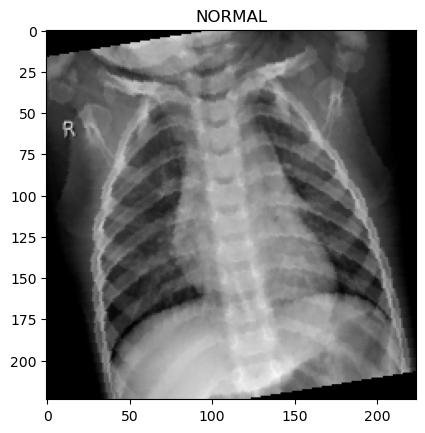

In [53]:
img,label=trainset[1]
class_name=['NORMAL','PNEUMONIA']
show_image(img,class_name[label])

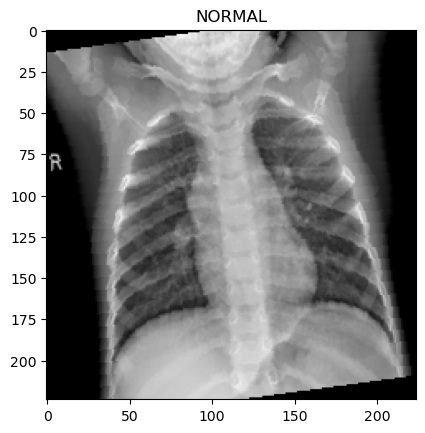

In [54]:
img,label=trainset[20]
class_name=['NORMAL','PNEUMONIA']
show_image(img,class_name[label])
# print(label)
# print(class_name[label])
# print(img

In [55]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [56]:
trainloader=DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) # Trainset Size: 5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:326
No. of Total examples:5216


In [57]:
validationloader=DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(validationloader))) # Validationset Size: 16 / batch_size: 16 = 1(No. of batches in validationl)
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in trainloader:1
No. of Total examples:16


In [58]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) # Testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:39
No. of Total examples:624


In [38]:
!pip install timm

     ---------------------------------------- 2.2/2.2 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 236.8/236.8 kB 3.7 MB/s eta 0:00:00
     -------------------------------------- 263.9/263.9 kB 5.4 MB/s eta 0:00:00


In [59]:
from torch import nn
import torch.nn.functional as F
import timm # pytorch image models

model=timm.create_model(CFG.model_name,pretrained=True)

In [60]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [61]:
for param in model.parameters():
    param.requires_grad=False
    


model.classifier=nn.Sequential(
    nn.Linear(in_features=1792,out_features=625),# 1792 is the input features originally given
    nn.ReLU(), # RELU to be the activation function
    nn.Dropout(p=0.3),

    nn.Linear(in_features=625,out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256,out_features=2),
)


In [62]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [43]:
!pip install torchsummary

In [63]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [64]:
class PneumoniaTrainer():
    
    def __init__(self,criterion=None,optimizer=None,schedular=None):
        self.criterion=criterion
        self.optimizer=optimizer
        self.schedular=schedular
        # initialization
        
    def train_batch_loop(self,model,trainloader):
        # training the model in batches
        train_acc=0
        train_loss=0
        # initially both are zero 
        
        
        for images,labels in tqdm(trainloader):# for the progress bar and get the data from the trainloader
            # move data to GPU
            images=images.to(device)
            labels=labels.to(device)
            
            logits=model(images)
            loss=self.criterion(logits,labels) # calculating loss
            
            
            # updating the gradient
            self.optimizer.zero_grad() # gradients to zero
            # n PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients
            # to zero before starting to do backpropragation
            # (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes.
            
            loss.backward() # update loss
            #  The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes)
            # once you call backward() on the loss.
             # So, the default action has been set to accumulate (i.e. sum) the gradients on every loss.backward() call.
            # Because of this, when you start your training loop, ideally you should zero out the gradients so that you 
            # do the parameter update correctly. Otherwise, the gradient would be a combination of the old gradient, 
            # which you have already used to update your model parameters, and the newly-computed gradient. 
            
            self.optimizer.step()
            # After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer
            # iterate over all parameters (tensors) it is supposed to update and 
            # use their internally stored grad to update their values.
            
            
            train_loss+=loss.item()
            train_acc+=accuracy(logits,labels)
        
        
        return train_loss/len(trainloader), train_acc/len(trainloader) # calculating the average
             
                
    # Train classifying layers in batches, this function loads the images and labels from the data loader.
    # It then delivers the data to the model for training.
    # After it finds the gradients.
    # Lastly, it returns the average training loss and average training accuracy.
    
    def valid_batch_loop(self,model,validloader):
        valid_loss=0.0
        valid_acc=0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to GPU
            images=images.to(device) 
            labels=labels.to(device)
            
            logits=model(images)
            loss=self.criterion(logits,labels)
            
            valid_loss+=loss.item()
            valid_acc+=accuracy(logits,labels)
            
        return valid_loss/len(validloader),valid_acc/len(validloader)
    
    # Very similar idea to the validation data. But we don’t need to update the gradients.
    
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss=np.Inf # initial loss is infinity 
        
        for i in range(epochs):
            model.train() # train in epochs turn on dropout
            avg_train_loss,avg_train_acc=self.train_batch_loop(model,trainloader)
            
            model.eval() # turns off the dropout and batch norm
            avg_valid_loss,avg_valid_acc=self.valid_batch_loop(model,validloader)
            
            
            if avg_valid_loss<=valid_min_loss:
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'EffNetPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss
                # whenever the validation loss is smaller than what it was before it gets saved
                
                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

            
        # validation loss goes down, the trained model gets saved by this function.


In [65]:
criterion=nn.CrossEntropyLoss()
# This criterion computes the cross entropy loss between input and target.
# Cross-entropy loss refers to the contrast between two random variables;
# it measures them in order to extract the difference in the information they contain, 
# showcasing the results. We use this type of loss function to calculate how accurate 
# our machine learning or deep learning model is by defining the difference between the estimated probability
# with our desired outcome.

optimizer=torch.optim.Adam(model.parameters(),lr=CFG.lr)
# Implements Adam algorithm
# Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent
# procedure to update network weights iterative based in training data.


'''
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning
rate does not change during training.
A learning rate is maintained for each network weight (parameter) 
'''

trainer=PneumoniaTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs=CFG.epochs)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.48810234665870667
Epoch : 1 Train Loss : 0.262419 Train Acc : 0.889954
Epoch : 1 Valid Loss : 0.488102 Valid Acc : 0.750000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.213410 Train Acc : 0.915836
Epoch : 2 Valid Loss : 1.214173 Valid Acc : 0.500000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.184919 Train Acc : 0.924847
Epoch : 3 Valid Loss : 0.956447 Valid Acc : 0.562500


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.48810234665870667 --> 0.41265133023262024
Epoch : 4 Train Loss : 0.183871 Train Acc : 0.927531
Epoch : 4 Valid Loss : 0.412651 Valid Acc : 0.875000


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.176174 Train Acc : 0.933666
Epoch : 5 Valid Loss : 0.467629 Valid Acc : 0.687500


In [66]:
 model.load_state_dict(torch.load('./EffNetPneumoniaModel.pt')) 
# Load the model data we saved
model.eval()

avg_test_loss,avg_test_acc=trainer.valid_batch_loop(model,testloader) 
# run it through the testing images

print("Test Loss: {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss: 0.26640249884281403
Test Acc : 0.8974359035491943


0


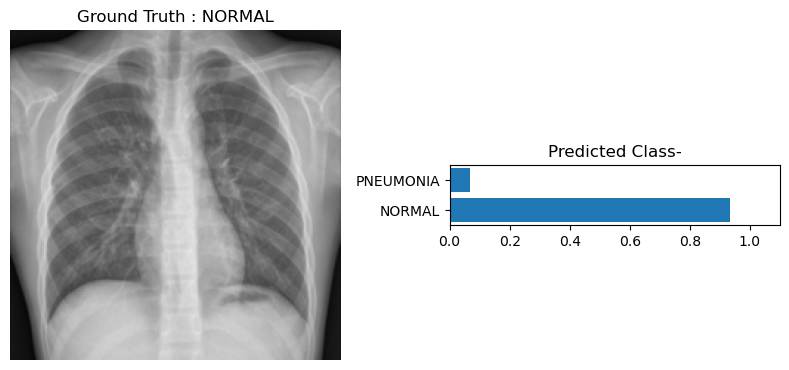

In [67]:
import torch.nn.functional as F

image,label=testset[13]
print(label)

ps=model(image.to(device).unsqueeze(0)) 
# unsqueeze- Returns a new tensor with a dimension of size one inserted at the specified position.

ps=F.softmax(ps,dim=1)
# Applies the Softmax function to an n-dimensional input Tensor rescaling them so that 
# the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.

view_classify(image,ps,label)

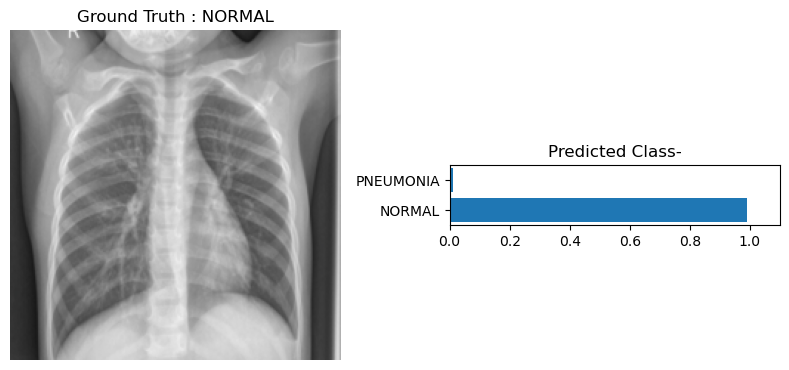

In [68]:
image,label=testset[5]

ps=model(image.to(device).unsqueeze(0))
ps=F.softmax(ps,dim=1)

view_classify(image,ps,label)

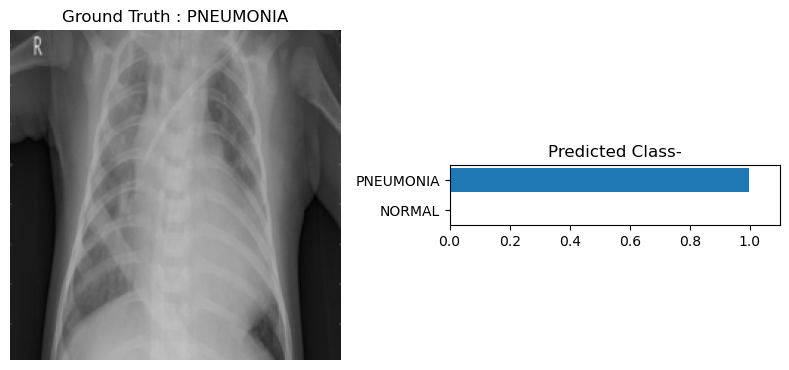

In [69]:
image,label=testset[300]

ps=model(image.to(device).unsqueeze(0))
ps=F.softmax(ps,dim=1)

view_classify(image,ps,label)


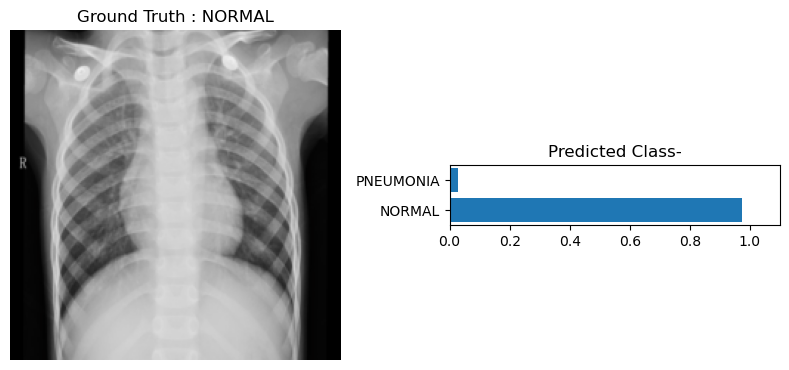

In [70]:
image,label=testset[115]

ps=model(image.to(device).unsqueeze(0))
ps=F.softmax(ps,dim=1)

view_classify(image,ps,label)